In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# CAVEAT

THIS NOTEBOOK IS JUST AN EXAMPLE OF CURVE FITTING ON SOME REAL WORD DATA.

PLEASE REFRAIN TO TAKE ANY DECISION OR TO EXTRAPOLATE ANY RECOMMANDATION BASED ON THIS NOTEBOOK.

**PLEASE STICK TO OFFICIAL RECOMMENDATION AND INFORMATION!**

* https://www.who.int/emergencies/diseases/novel-coronavirus-2019

# Load the data provided by JHU 

In [2]:
# Data source: https://github.com/CSSEGISandData/COVID-19
!cd DATA && git pull && cd ../

Already up to date.


In [3]:
df_confirmed = pd.read_csv('DATA/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

In [4]:
# Drop data from 2020-03-12 because for many country data for this day was a replica from the previous day.
df_confirmed.drop(columns=['3/12/20'], inplace=True)

In [5]:
# Pivot the data: wide to long
df_confirmed_pivoted = df_confirmed.set_index(['Province/State', 'Country/Region', 'Lat', 'Long']).stack().to_frame('Cases').reset_index()
df_confirmed_pivoted = df_confirmed_pivoted.rename(columns={'level_4' : 'Date'})
df_confirmed_pivoted['Date'] = pd.to_datetime(df_confirmed_pivoted['Date'])
df_confirmed_pivoted = df_confirmed_pivoted.groupby(['Country/Region','Date'])['Cases'].sum().to_frame('Cases').reset_index()

# Models and other amenities

In [397]:
# Exponential model
def exponential_model(x, *pars): 
    return pars[0]+np.exp(pars[1]*x+pars[2])

# Logistic model
def logistic_model(x, *pars): 
    return pars[0]+pars[1]/(1+np.exp(-pars[2]*(x-pars[3])))

def fit_model(xdata, ydata, model, p0=[1,1,1]):

    popt, pcov = scipy.optimize.curve_fit(model, xdata, ydata,
                                          p0=p0, 
                                          method='trf',
                                          sigma=np.sqrt(ydata),
                                          absolute_sigma=False,
                                          max_nfev=50000)

    r_square = 1 - np.square(ydata-model(xdata, *popt)).sum() / np.var(ydata)
    
    return popt, pcov, r_square

def model_error(xdata, model, pars, cov):
    
    func = lambda pars, args : model(args, *pars)

    eps = np.finfo(np.float16).eps

    err = []
    for x in xdata:
        g = scipy.optimize.approx_fprime(pars, func, eps, x)
        e = np.sqrt(np.dot(g, np.dot(cov,g.T)))
        err.append(e)
        #print(x,popt,g,e)
    
    err=np.array(err)
    return err

def print_fit_results(popt, pcov, r_square):
    
    print('Fit Parameters:')
    print(popt)
    print()
    print('Covariance matrix:')
    print(pcov)
    print()
    print('R-square: %.3f'% r_square)

def forecast(start_date, start_day, n_days, model, popt, pcov):
    
    index = np.arange(start_day, start_day+n_days)
    
    #perr = np.sqrt(np.diag(pcov))
    
    forecast = model(index, *popt)
    error = model_error(index, model, popt, pcov)

    df = pd.DataFrame(
        index=index,
        data={
            'Date': pd.date_range(start=start_date, periods=n_days),
            'Forecast' : forecast,
            '1s_sup' : forecast+error,
            '1s_inf' : forecast-error,
            '2s_sup' : forecast+2*error,
            '2s_inf' : forecast-2*error,
            #'Forecast_sup' : model(index, *(popt+perr)),
            #'Forecast_inf' : model(index, *(popt-perr)),
         }
    )
    
    df['Uncertainty'] = error

    return df
    
def predict(dates, days, model, popt, pcov):
    
    #perr = np.sqrt(np.diag(pcov))
    
    pred = model(days, *popt)
    error = model_error(days, model, popt, pcov)

    
    df = pd.DataFrame(
        data={
            'Date': dates,
            'Model' : pred,
            '1s_sup' : pred+error,
            '1s_inf' : pred-error,
            '2s_sup' : pred+2*error,
            '2s_inf' : pred-2*error,
            #'Model_sup' : model(days, *(popt+perr)),
            #'Model_inf' : model(days, *(popt-perr)),
         }
    )
    
    df['Uncertainty'] = error

    return df

# Fit data for Italy

In [398]:
# The same fit works for other country, but the intitial fit parameters must be carefully tuned
dfit = df_confirmed_pivoted.loc[df_confirmed_pivoted['Country/Region'] == 'Italy'].reset_index(drop=True)
dfit = dfit.loc[dfit['Cases'] > 10]

dfit['ndays'] = (dfit['Date'] - dfit['Date'].iloc[0]).dt.days

ydata=dfit['Cases'] 
xdata=dfit['ndays']

# Logistic model
print()
print('-----------------')
print('Logistic model')
print('-----------------')
print()
p0=[10, 4.57770247e+04,  2.26454719e-01,  5.34455732e+01]
popt, pcov, r_square_logit = fit_model(xdata,ydata,logistic_model, p0=p0)
print_fit_results(popt, pcov, r_square_logit)
df_predict_logit = predict(dfit['Date'].values, dfit['ndays'].values, logistic_model, popt, pcov)
df_forecast_logit = forecast(dfit['Date'].values[-1], dfit['ndays'].values[-1], 30, logistic_model, popt, pcov)

# Exponential model
print()
print('-----------------')
print('Exponential model')
print('-----------------')
print()
p0=[-7.37533982e+02,1.68721374e-01,6.27460550e+00]
popt, pcov, r_square_exp = fit_model(xdata, ydata, exponential_model, p0=p0)
print_fit_results(popt, pcov, r_square_exp)
df_predict_exp = predict(dfit['Date'].values, dfit['ndays'].values, exponential_model, popt, pcov)
df_forecast_exp = forecast(dfit['Date'].values[-1], dfit['ndays'].values[-1], 10, exponential_model, popt, pcov)


-----------------
Logistic model
-----------------

Fit Parameters:
[-2.48683773e+02  7.34408755e+04  2.15791719e-01  2.61393890e+01]

Covariance matrix:
[[ 6.09585855e+02 -1.89040287e+05  1.24916800e-01 -1.90083704e+01]
 [-1.89040287e+05  1.00454590e+08 -5.15840121e+01  9.66888086e+03]
 [ 1.24916800e-01 -5.15840121e+01  3.10159905e-05 -5.12393708e-03]
 [-1.90083704e+01  9.66888086e+03 -5.12393708e-03  9.37789606e-01]]

R-square: 0.985

-----------------
Exponential model
-----------------

Fit Parameters:
[-3.92957278e+02  1.82927757e-01  5.96175156e+00]

Covariance matrix:
[[ 1.08138995e+03  8.90418266e-02 -1.84176639e+00]
 [ 8.90418266e-02  9.52331467e-06 -1.87457111e-04]
 [-1.84176639e+00 -1.87457111e-04  3.82653039e-03]]

R-square: 0.955


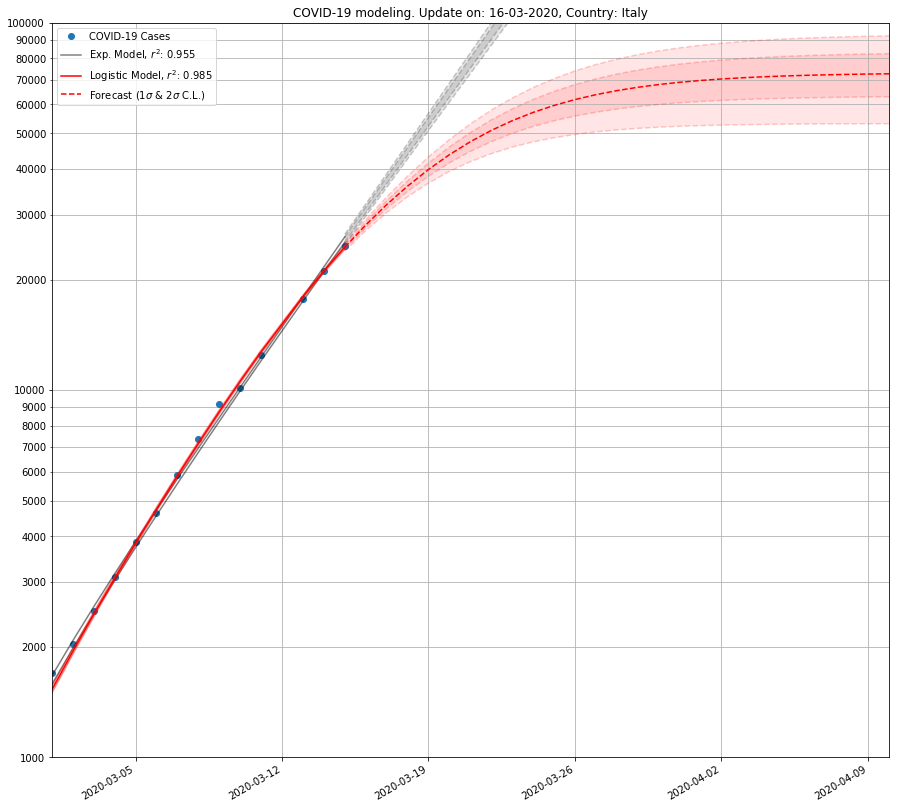

In [410]:
# Draw
_,ax = plt.subplots(figsize=(15,15))
logy=True
# Data
dfit.plot('Date', 'Cases', marker='o', linestyle="None", label='COVID-19 Cases', ax=ax, logy=logy)

# Exponential Model
#df_predict_exp.plot('Date', 'Model', color='k', linestyle='-', alpha=1, label='_nolegend_', ax=ax)
df_predict_exp.plot('Date', '1s_sup', color='k', linestyle='-', alpha=0.5, label='Exp. Model, $r^2$: %.3f'% r_square_exp, ax=ax)
df_predict_exp.plot('Date', '1s_inf', color='k', linestyle='-', alpha=0.5, label='_nolegend_', ax=ax)
# Exponential Model Forecast
#df_forecast_exp.plot('Date', 'Forecast', color='k', linestyle='--', alpha=1, label='_nolegend_', ax=ax)
df_forecast_exp.plot('Date', '1s_sup', color='k', linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
df_forecast_exp.plot('Date', '1s_inf', color='k', linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
df_forecast_exp.plot('Date', '2s_sup', color='k', linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
df_forecast_exp.plot('Date', '2s_inf', color='k', linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
ax.fill_between(df_forecast_exp['Date'], df_forecast_exp['1s_inf'], df_forecast_exp['1s_sup'], facecolor="k", alpha=0.1)
ax.fill_between(df_forecast_exp['Date'], df_forecast_exp['2s_inf'], df_forecast_exp['2s_sup'], facecolor="k", alpha=0.1)

# Logistic Model
df_predict_logit.plot('Date', 'Model', color='r', linestyle='-', alpha=1, label='Logistic Model, $r^2$: %.3f'% r_square_logit, ax=ax)
df_predict_logit.plot('Date', '1s_sup', color='r', linestyle='-', alpha=0.5, label='_nolegend_', ax=ax)
df_predict_logit.plot('Date', '1s_inf', color='r', linestyle='-', alpha=0.5, label='_nolegend_', ax=ax)
# Logistic Model Forecast
df_forecast_logit.plot('Date', 'Forecast', color='r', linestyle='--', alpha=1, label='Forecast ($1\sigma$ & $2\sigma$ C.L.)', ax=ax)
df_forecast_logit.plot('Date', '1s_sup', color='r', linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
df_forecast_logit.plot('Date', '1s_inf', color='r', linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
df_forecast_logit.plot('Date', '2s_sup', color='r', linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
df_forecast_logit.plot('Date', '2s_inf', color='r', linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
ax.fill_between(df_forecast_logit['Date'], df_forecast_logit['2s_inf'], df_forecast_logit['2s_sup'], facecolor="red", alpha=0.1)
ax.fill_between(df_forecast_logit['Date'], df_forecast_logit['1s_inf'], df_forecast_logit['1s_sup'], facecolor="red", alpha=0.1)

formatter = matplotlib.ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_minor_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

from datetime import datetime    
plt.title('COVID-19 modeling. Update on: %s, Country: %s' %(datetime.today().strftime('%d-%m-%Y'),dfit['Country/Region'].values[0]))
plt.grid(axis='both',which='both')
plt.xlabel('')

#Axis limit
ax.set_xlim(['2020-03-01','2020-04-10'])
ax.set_ylim([1000, 100000])

# Zoom
#ax.set_xlim(['2020-03-13','2020-03-16'])
#ax.set_ylim([20000, 28000])

plt.show()

## Logistic model: forecast 30 days ahead

In [411]:
display(df_forecast_logit)

,Date,Forecast,1s_sup,1s_inf,2s_sup,2s_inf,Uncertainty
23,2020-03-15,24488.387784,24787.834410,24188.941158,25087.281036,23889.494532,299.446626
24,2020-03-16,28142.936229,28638.150235,27647.722223,29133.364242,27152.508216,495.214006
25,2020-03-17,31980.118720,32761.173294,31199.064147,33542.227867,30418.009573,781.054573
26,2020-03-18,35919.538800,37079.496211,34759.581390,38239.453621,33599.623979,1159.957411
27,2020-03-19,39871.714142,41501.253180,38242.175104,43130.792217,36612.636066,1629.539038
28,2020-03-20,43746.004147,45926.313686,41565.694607,48106.623226,39385.385067,2180.309540
29,2020-03-21,47458.755340,50254.629391,44662.881288,53050.503443,41867.007236,2795.874052
30,2020-03-22,50940.153686,54394.912610,47485.394761,57849.671534,44030.635837,3454.758924
31,2020-03-23,54138.668588,58271.844440,50005.492737,62405.020291,45872.316886,4133.175851
32,2020-03-24,57022.655593,61830.586885,52214.724300,66638.518178,47406.793008,4807.931293
